In [3]:
import numpy as np
import matplotlib.pyplot as plt
import figurefirst

# Empirical local observability gramian

In [4]:
nsamples = 1000

In [5]:
# simulate the system
state_idx = {'p': 0, 'v': 1, 'a': 2, 'k': 3}


def step_forward(x0, dt, t, observable_states):
    p, v, a, k = x0
    x1 = [p+v*dt, v + a*dt, a + k*v*dt, k]
    idx = [state_idx[s] for s in observable_states]
    y1 = [x1[i] for i in idx]
    return x1, y1

def simulate(x0, dt, observable_states=['p', 'v', 'a', 'k']):
    xs = [x0]
    ys = []
    t = 0
    for i in range(nsamples):
        x1, y1 = step_forward(xs[-1], dt, t, observable_states)
        xs.append(x1)
        ys.append(y1)
        t += dt
        
    ys = np.array(ys)
        
    return np.array(xs[1:]), ys

In [6]:
def numerical_gramian(x0, dt, eps=1e-3, observable_states=['p', 'v', 'a', 'k']):
    
    x0_eps = [x0[0]+eps, x0[1], x0[2], x0[3]]
    xs, ys_p_plus = simulate(x0_eps, dt, observable_states=observable_states)

    x0_eps = [x0[0]-eps, x0[1], x0[2], x0[3]]
    xs, ys_p_minus = simulate(x0_eps, dt, observable_states=observable_states)

    x0_eps = [x0[0], x0[1]+eps, x0[2], x0[3]]
    xs, ys_v_plus = simulate(x0_eps, dt, observable_states=observable_states)

    x0_eps = [x0[0], x0[1]-eps, x0[2], x0[3]]
    xs, ys_v_minus = simulate(x0_eps, dt, observable_states=observable_states)

    x0_eps = [x0[0], x0[1], x0[2]+eps, x0[3]]
    xs, ys_a_plus = simulate(x0_eps, dt, observable_states=observable_states)

    x0_eps = [x0[0], x0[1], x0[2]-eps, x0[3]]
    xs, ys_a_minus = simulate(x0_eps, dt, observable_states=observable_states)
    
    x0_eps = [x0[0], x0[1], x0[2], x0[3]+eps]
    xs, ys_k_plus = simulate(x0_eps, dt, observable_states=observable_states)

    x0_eps = [x0[0], x0[1], x0[2], x0[3]-eps]
    xs, ys_k_minus = simulate(x0_eps, dt, observable_states=observable_states)

    Ps = []
    arr0 = np.matrix(np.vstack( (ys_p_plus[0]-ys_p_minus[0], 
                                 ys_v_plus[0]-ys_v_minus[0], 
                                 ys_a_plus[0]-ys_a_minus[0],
                                 ys_k_plus[0]-ys_k_minus[0]) ))  # at t0
    
    # get the inside of the integral for each time point
    for i in range(len(xs)):
        arr = np.matrix(np.vstack( ( ys_p_plus[i]-ys_p_minus[i], 
                                     ys_v_plus[i]-ys_v_minus[i], 
                                     ys_a_plus[i]-ys_a_minus[i],
                                     ys_k_plus[i]-ys_k_minus[i]) ))  # at tf
        
        P = ((arr*arr.T)-(arr0*arr0.T))
        Ps.append(P)

    cn = []
    
    # now take the integral
    for i in range(1, len(xs)):
        P = np.sum(Ps[0:i], axis=0)*i*dt/(4*eps**2)
        u,s,v = np.linalg.svd(P)
        cn.append( np.max(s) / np.min(s) )
        
    return np.array(cn), xs

In [7]:
def make_gramian_plot(ax, x0, add_noise=False):
    dt = 0.0001

    cn, xs = numerical_gramian(x0, dt, observable_states=['p'])
    idx = np.arange(0, len(cn)-1, 1).astype(int)
    ax.loglog(idx, cn[idx], ':', color='red', markersize=3, markeredgecolor='none')

    cn, xs = numerical_gramian(x0, dt, observable_states=['p', 'k'])
    ax.loglog(idx, cn[idx], color='red')

    cn, xs = numerical_gramian(x0, dt, observable_states=['p', 'v'])
    ax.loglog(idx, cn[idx], ':', color='blue', markersize=3, markeredgecolor='none')

    cn, xs = numerical_gramian(x0, dt, observable_states=['p', 'v', 'k'])
    ax.loglog(idx, cn[idx], color='blue')

    cn, xs = numerical_gramian(x0, dt, observable_states=['p', 'v', 'a'])
    ax.loglog(idx, cn[idx], ':', color='black', markersize=3, markeredgecolor='none')

    cn, xs = numerical_gramian(x0, dt, observable_states=['p', 'v', 'a', 'k'])
    ax.loglog(idx, cn[idx], color='black')

    
    return xs

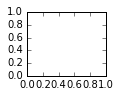

In [8]:
layout = figurefirst.svg_to_axes.FigureLayout('empirical_gramian_figure.svg',
                                              autogenlayers=True,
                                              make_mplfigures=True,
                                              hide_layers=[])

In [9]:
x0 = [1, 0.1, 0.5, 0.2]

ax = layout.axes[('gramian', 'A')]
xs = make_gramian_plot(ax, x0)
figurefirst.mpl_functions.adjust_spines(ax, ['left', 'bottom'], tick_length=2.5, linewidth=0.5)
ax.set_ylabel('Log Condition Number')
ax.set_xlabel('Time, samples')

figurefirst.mpl_functions.set_fontsize(ax, 6)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in double_scalars


In [10]:
layout.append_figure_to_layer(layout.figures['gramian'], 'gramian', cleartarget=True)
layout.write_svg('empirical_gramian_figure.svg')

/usr/lib/python2.7/dist-packages/matplotlib/scale.py:93: RuntimeWarning: invalid value encountered in less_equal
  mask = a <= 0.0


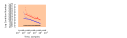

In [11]:
from IPython.display import display,SVG
display(SVG('empirical_gramian_figure.svg'))